<div class="alert alert-block alert-success">
    <h1 align="center"> Neural network based on mathematical relations in Python</h1>
    <h3 align="center"></h3>
</div>

<img src = "https://www.ionos.de/digitalguide/fileadmin/DigitalGuide/Teaser/ki-t.jpg" width=100%>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import  matplotlib.pyplot as plt

In [2]:

file = pd.read_csv('../input/cancer-example/cancer.csv')
data = file.to_numpy()
inputs = data[:, :9]
outputs = data[:, 9]



In [3]:
"""
 ---- Shuffle ----
"""
per_list = np.random.permutation(len(data))
inputs_sh = []
outputs_sh = []
for i in range(len(data)):
    per_idx = per_list[i]
    tmp_input = inputs[per_idx]
    tmp_output = outputs[per_idx]
    inputs_sh.append(tmp_input)
    outputs_sh.append(tmp_output)
inputs_sh = np.array(inputs_sh)
outputs_sh = np.array(outputs_sh)


In [4]:
"""
 ---- Normalize data ----
 (inputs - min) / (max - min)
"""
min_vec = inputs_sh.min(axis = 0)
max_vec = inputs_sh.max(axis=0)
inputs_sh = (inputs_sh - min_vec) / (max_vec - min_vec)

In [5]:
"""
 ---- spliting data ----
"""
trn_test_split = int(0.75 * len(inputs_sh))
X_train = inputs_sh[0:trn_test_split , : ]
Y_train = outputs_sh[0 : trn_test_split]

X_val = inputs_sh[trn_test_split : , :]
Y_val = outputs_sh[trn_test_split : ,]

In [6]:
"""
 ---- Structure of Neural Network ----
"""
n0 = 9 # input layer
n1 = 8 # first hidden layer
n2 = 4 # second hidden layer
n3 = 1 # output layer

w1 = np.random.uniform(low=-1,high= +1,size=(n1,n0))
w2 = np.random.uniform(low=-1,high= +1,size=(n2,n1))
w3 = np.random.uniform(low=-1,high= +1,size=(n3,n2))

In [7]:
# activation function
def activation(x):
    y = 1/(1 + np.exp(-1 * x))
    return y


In [8]:
# feedforward algorithm
def feedforward(input_net):
    # inputs * w1 --> x1 , y1= sigmoid(x1) , y1 * w2 --> x2
    # y2 = sigmoid(x2) , y2 * w3 --> x3 , y3 = sigmoid(x3) , y3 : output
    x1 = np.dot(input_net , w1.T)
    y1 = activation(x1)
    x2 = np.dot(y1 , w2.T)
    y2 = activation(x2)
    x3 = np.dot(y2 , w3.T)
    y3 = activation(x3)

    return y1 , y2 , y3

In [9]:
# Backpropagation
def d_activation(out):
    # y = sigmoid(x) --> d_y = y * (1 - y)
    d_y = out * ( 1 - out)
    return d_y

In [10]:
epochs = 500
lr = 0.001

list_AccTrain = []
list_MseTrain = []
list_AccValid = []
list_MseValid = []

for i in range(epochs):
    for j in range(len(X_train)):
        input = X_train[j] # shape input = (n0,)
        input = np.reshape(input , newshape=(1,n0)) # shape input = (1,n0)
        target = Y_train[j]

        y1 , y2 , y3 = feedforward(input)
        error = target - y3

        # w1 = w1 - lr * (-2/N)*(error) * d_f3 * w3 * d_f2 * w2 * d_f1 * ...
        # ... * input
        # (-2/N) * error : N-->1
        # w1.shape = (n1 , n0)
        # d_f3.shape = (1,n3) = (1,1)
        # w3.shape = (n3 , n2) -- > d_f3 * w3 : shape= (1,n2)
        # d_f2.shape = (1, n2) --> diagonal(d_f2) : shape= (n2,n2)
        # d_f3 * w3 * diagonal(d_f2) --> shape = (1 , n2)
        # w2.shape = ( n2 , n1)
        # d_f3 * w3 * ( diagonal(d_f2) * w2 --> shape = (1,n1)
        # d_f1.shape = (1, n1) --> diagonal(d_f1) --> shape = (n1 , n1)
        # matrix1 * diagonal(d_f1) --> shape = (1, n1) --> matrix2.T --> shape=(n1,1)
        # input.shape = (1 , n0)
        # matrix2.T * input --> shape = (n1 , n0)

        d_f3 = d_activation(y3)

        d_f2 = d_activation(y2)
        diag_d_f2 = np.diagflat(d_f2)

        d_f1 = d_activation(y1)
        diag_d_f1 = np.diagflat(d_f1)

        temp1 = -2 * error * d_f3
        temp2 = temp1 * w3    #  or  np.dot(temp1 , w3)
        temp3 = np.dot(temp2 , diag_d_f2)
        temp4 = np.dot(temp3 , w2)
        temp5 = np.dot(temp4 , diag_d_f1)
        temp5 = temp5.T
        temp6 = np.dot(temp5 , input)

        w1 = w1 - lr * temp6

        # w2 = w2 - lr * ((-2/N)*error * d_f3 * w3 * diag_d_f2).T * y1
        w2 = w2 - lr * np.dot(temp3.T , y1)

        # w3 = w3 - lr * (-2/N)*error * d_f3 * y2
        w3 = w3 - lr * np.dot(temp1.T , y2)
    # calculate and MSE train ::

    Netoutput_Train = []
    target_Train =[]
    rnd_Netoutput_Train = []
    for idx in range(len(X_train)):
        input = X_train[idx]
        target = Y_train[idx]
        target_Train.append(target)

        _ ,_ ,pred = feedforward(input)
        Netoutput_Train.append(pred)
        rnd_Netoutput_Train.append(np.round(pred))
    mse_train = mse(target_Train ,Netoutput_Train)
    #mse_train1 = np.square(np.subtract(target_Train,Netoutput_Train)).mean()
    list_MseTrain.append(mse_train)

    acc_train = acc(target_Train, rnd_Netoutput_Train)
    list_AccTrain.append(acc_train)
    print('epoch ' ,i , ' :MSE_Train = ' , mse_train ,'\tACC_TRAIN = ' ,acc_train)

# calculate and MSE Valid ::

    Netoutput_val = []
    target_val =[]
    rnd_Netoutput_val = []
    for idx in range(len(X_val)):
        input = X_val[idx]
        target = Y_val[idx]
        target_val.append(target)

        _ ,_ ,pred = feedforward(input)
        Netoutput_val.append(pred)
        rnd_Netoutput_val.append(np.round(pred))
    mse_val = mse(target_val ,Netoutput_val)
    #mse_val1 = np.square(np.subtract(target_val, Netoutput_val)).mean()
    list_MseValid.append(mse_val)

    acc_val= acc(target_val, rnd_Netoutput_val)
    list_AccValid.append(acc_val)
    print('epoch ' ,i , ' :MSE_val = ' , mse_val ,'\tACC_val = ' ,acc_val)
    print('---------------------------------------------------------')


epoch  0  :MSE_Train =  0.2559541758606557 	ACC_TRAIN =  0.35946462715105165
epoch  0  :MSE_val =  0.2538853414333025 	ACC_val =  0.4114285714285714
---------------------------------------------------------
epoch  1  :MSE_Train =  0.25292933868506945 	ACC_TRAIN =  0.627151051625239
epoch  1  :MSE_val =  0.24860850568160386 	ACC_val =  0.7142857142857143
---------------------------------------------------------
epoch  2  :MSE_Train =  0.2504089357944587 	ACC_TRAIN =  0.6309751434034416
epoch  2  :MSE_val =  0.24405458946606343 	ACC_val =  0.7257142857142858
---------------------------------------------------------
epoch  3  :MSE_Train =  0.24830469667332059 	ACC_TRAIN =  0.6309751434034416
epoch  3  :MSE_val =  0.24011585172599456 	ACC_val =  0.7257142857142858
---------------------------------------------------------
epoch  4  :MSE_Train =  0.24654273369457191 	ACC_TRAIN =  0.6309751434034416
epoch  4  :MSE_val =  0.2366997243857671 	ACC_val =  0.7257142857142858
----------------------

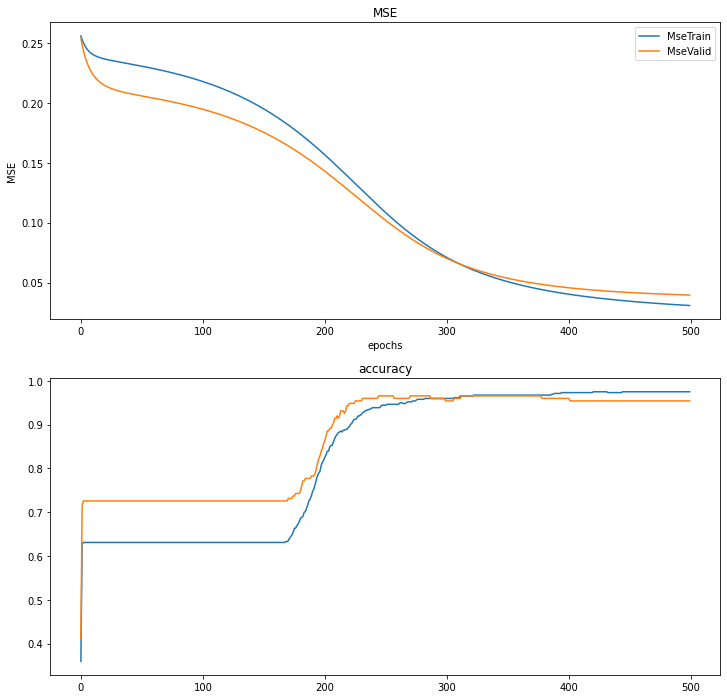

In [11]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.title('MSE')
plt.plot(list_MseTrain,label = 'MseTrain')
plt.plot(list_MseValid , label = 'MseValid')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')

plt.subplot(2,1,2)
plt.title('accuracy')
plt.plot(list_AccTrain ,label = 'AccTrain')
plt.plot(list_AccValid , label = 'AccTrain')
plt.show()

Good luck!